In [1]:
import numpy as np 
import tensorly as tl
import sys
sys.path.append("../mfda/")
from tensor_decomposition import MARGARITA
from hyperparam_selection import tfold_cross_val
from marginal_product_basis import MPB
from utility import FPCA 
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import Fourier, BSpline, Tensor
from skfda.misc.operators import LinearDifferentialOperator, gram_matrix
from skfda.preprocessing.smoothing import BasisSmoother
from skfda import FDataGrid

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from collections import namedtuple 
import time 
import os 
import itertools 
import pickle 
import scipy 
from scipy.stats import ortho_group, sem
import pandas as pd 
import functools 
import operator 

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

svdtuple = namedtuple("SVD", ["U", "s", "Vt"])
DATA_DIR = "data"

%load_ext autoreload
%autoreload 2

In [2]:
####UTILITY FUNCTIONS#####
def kompb(Y, K, pen_params, reg_type="l2"):
    ## Compute basis evaluation matrices and SVDs
    Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
    ## Perform the n-mode coordinate transformations into the spline coefficient space 
    ## Y_Bar should be close to zero so no need to center 
    G = tl.tenalg.multi_mode_dot(Y, [svdt.U.T for svdt in Svds], list(range(nmode)))
    ## Estimation MPB
    maxiter = (200, 100)
    tol_inner = (1e-3, 1e-3)
    tol_outer = 1e-3
    initialize = "random"
    Vs = [Svds[d].Vt.T for d in range(nmode)]
    Dinvs = [np.diag(1./Svds[d].s) for d in range(nmode)]
    Tlst_bcd = [Dinvs[d]@Vs[d].T@Rlst[d]@Vs[d]@Dinvs[d] for d in range(nmode)]
    start = time.time()
    Ctilde, Smat, scalars, FLAG_C, FLAG_N = MARGARITA(G, Tlst_bcd, pen_params, K, 
                                     max_iter=maxiter, tol_inner=tol_inner, 
                                     tol_outer=tol_outer,  regularization=reg_type, init=initialize, 
                                    verbose=False)
    elapsed = time.time() - start
    Clst = [Svds[d].Vt.T @ np.diag(1/Svds[d].s) @ Ctilde[d] for d in range(nmode)] 
    Smat_scaled = np.multiply(Smat, scalars)
    Zeta_tensor = np.zeros(tuple([K] + list(Y.shape[:-1])))
    for k in range(K):
        Zeta_tensor[k,...] = np.prod(np.ix_(*[Phis[d] @ Clst[d][:,k] for d in range(nmode)]))
    return Zeta_tensor, Clst, Ctilde, Smat_scaled 

## Wrapper function for two stage FPCA 
def two_stage_fpca(Zeta_tensor, Clst, Smat_scaled):
    mpb = MPB(bspline_basis, Clst)
    ## Perform FPCA 
    J = mpb.gram_matrix()
    R = mpb.roughness_matrix()
    B, gamma = FPCA(Smat_scaled, J, R, lam=1e-10) ##already smoothed the marginal functions
    Eta_tensor = tl.tenalg.mode_dot(Zeta_tensor, B.T, 0)
    return Eta_tensor, gamma

In [3]:
## Random-field (Section 5.2, but in principle can investigate performance for different fields)
np.random.seed(15) ## make exactly reproducible 

n1 = 200
n2 = 200
m1 = 10
m2 = 8
bsp1 = BSpline(n_basis=m1, order=4)
bsp2 = BSpline(n_basis=m2, order=4)
nds = (n1, n2)
mds = (m1, m2)
r = np.prod(mds)

## fixed field parameters 
nmode = 2
bspline_basis = [bsp1, bsp2] ## use true marginal basis systems for all fitting methods 
xgrids = [np.linspace(0,1,n1),
         np.linspace(0,1,n2)]
Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]

X = np.array(list(itertools.product(*xgrids)))
tp_basis = Tensor([bsp1, bsp2])
J_tp = tp_basis.gram_matrix()

Phi = np.squeeze(tp_basis.evaluate(X)).T

alpha = 0.5
lambdas = np.exp(-alpha*np.arange(r)) #exponential decay model for eigenfunctions 

s_tp, P_tp = np.linalg.eigh(J_tp)
Coefs = np.diag(np.sqrt(1./s_tp))@P_tp.T 

Q = ortho_group.rvs(m1*m2)
Coefs = Q@Coefs

Psi_tensor = np.zeros(tuple([r] + list(nds)))
for k in range(r):
    Psi_tensor[k,...] = (Phi @ Coefs[k,:]).reshape(n1,n2)

## define simulator 
def sample_field(N):
    Y = np.zeros(tuple(list(nds)+[N]))
    Psi_coefs = np.random.multivariate_normal(np.zeros(r), 
                                              np.diag(lambdas), 
                                              size=N) ##sample field coefs
    for n in range(N): 
        Y[...,n] = functools.reduce(operator.add, map(lambda k: Psi_coefs[n,k]*Psi_tensor[k,...], 
                                                     np.arange(r)))
    return Y

def sample_field_sparse(N):
    Y = np.zeros(tuple(list(nds)+[N]))
    
    Psi_coefs = np.random.multivariate_normal(np.zeros(r), 
                                              np.diag(lambdas), 
                                              size=N) ##sample field coefs
    
    Psi_coefs_1 = Psi_coefs.copy(); Psi_coefs_2 = Psi_coefs.copy()
    Psi_coefs_1[:int(N/2),1:] = 0
    Psi_coefs_2[int(N/2):,0] = 0
    Psi_coefs_2[int(N/2):,2:] = 0

    for n in range(N): 
        if n < int(N/2):
            Y[...,n] = functools.reduce(operator.add, map(lambda k: Psi_coefs_1[n,k]*Psi_tensor[k,...], 
                                                     np.arange(r)))
        else:
            Y[...,n] = functools.reduce(operator.add, map(lambda k: Psi_coefs_2[n,k]*Psi_tensor[k,...], 
                                                     np.arange(r)))
    return Y

# Maginal Rank Selection

In [4]:
## simulation parameters 
Nrep = 25
Ntrain = 100
#marg_ranks = [10, 15, 20, 30, 40, 50]
marg_ranks = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
results_marg_rank = []

sigma2s = [0.1, 1.0]
SNRs = np.sum(lambdas)/sigma2s

for sigma2 in sigma2s:
    mar_var_estims = np.zeros((Nrep,len(marg_ranks)))
    for rep in range(Nrep):
        Y_true = sample_field(Ntrain)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        for mi, mr in enumerate(marg_ranks):
            bspline_basis_mr = [BSpline(n_basis=mr, order=4) for d in range(nmode)]
            Phis_mr = [np.squeeze(bspline_basis_mr[d].evaluate(xgrids[d])).T for d in range(nmode)]
            Svds = [svdtuple(*np.linalg.svd(Phis_mr[d], full_matrices=False)) for d in range(nmode)]
            G_mr = tl.tenalg.multi_mode_dot(Y_noisey, [svdt.U.T for svdt in Svds], list(range(nmode)))
            mar_var_estims[rep, mi] = tl.norm(G_mr)**2/tl.norm(Y_noisey)**2
    results_marg_rank.append(mar_var_estims)

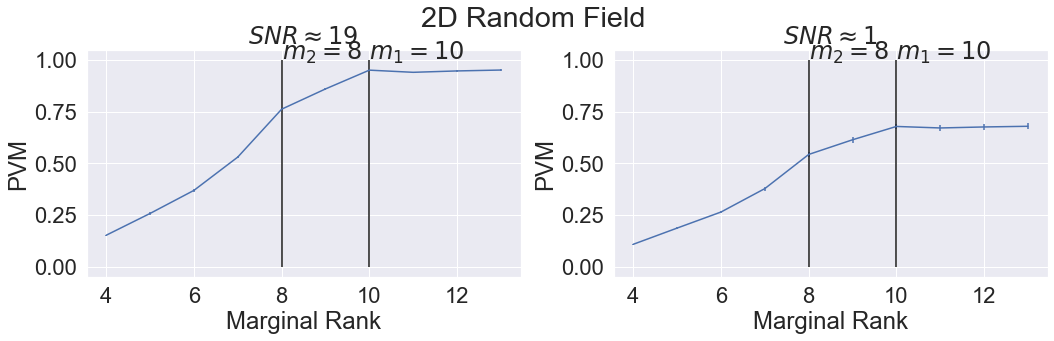

In [5]:
sns.set(font_scale = 2)

f, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].errorbar(marg_ranks, np.mean(results_marg_rank[0], axis=0), yerr=np.std(results_marg_rank[0], axis=0))
ax[0].set_xlabel("Marginal Rank")
ax[0].set_ylabel("PVM")
ax[0].set_title(r'$SNR \approx %s$'%int(SNRs[0]))
ax[0].vlines(m1,0,1)
ax[0].vlines(m2,0,1)
ax[0].text(m1,1,r'$m_1=10$',rotation=0)
ax[0].text(m2,1,r'$m_2=8$',rotation=0)


ax[1].errorbar(marg_ranks, np.mean(results_marg_rank[1], axis=0), yerr=np.std(results_marg_rank[1], axis=0))
ax[1].set_xlabel("Marginal Rank")
ax[1].set_ylabel("PVM")
ax[1].set_title(r'$SNR \approx %s$'%int(SNRs[1]))
ax[1].vlines(m1,0,1)
ax[1].vlines(m2,0,1)
ax[1].text(m1,1,r'$m_1=10$',rotation=0)
ax[1].text(m2,1,r'$m_2=8$',rotation=0)

plt.suptitle("2D Random Field")
f.tight_layout()

#plt.savefig("../../figures/sim_52_margrank.pdf")

# Global Rank Selection

In [5]:
## Global parameters 
mds_fit = (m1, m2)
bspline_basis = [BSpline(n_basis=mds_fit[d], order=4) for d in range(nmode)] 
Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]
Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
## Specify differential operator for penalization 
D2 = LinearDifferentialOperator(2)
Rlst = [gram_matrix(D2, bspline_basis[d]) for d in range(nmode)] 

## simulation parameters 
results_global_rank = []
pen_params = (1e-10, 1e-10, 1e-10) ## fix for rank selection

Ks = [5, 10, 15, 20, 25, 30, 35, 40]
results_global_rank = []

PVE_thresh = 0.995
K_select_results = {}
for sigma2 in sigma2s:
    glob_var_estims = np.zeros((Nrep,len(Ks)))
    Kselcted = np.zeros(Nrep)
    for rep in range(Nrep):
        Y_true = sample_field(Ntrain)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        G = tl.tenalg.multi_mode_dot(Y_noisey, [svdt.U.T for svdt in Svds], list(range(nmode)))
        for ki, K in enumerate(Ks):
            Zeta_tensor, Clst, Ctilde, Smat_scaled = kompb(Y_noisey, K, pen_params, reg_type="l2")
            Ghat = np.zeros(tuple(list(mds_fit) + [Ntrain]))
            for k in range(K):
                Ghat = Ghat + np.prod(np.ix_(*[Ctilde[d][:, k] for d in range(nmode)]+[Smat_scaled[:,k]]))
            glob_var_estims[rep,ki] = tl.norm(Ghat)**2/tl.norm(G)**2
        try: 
            Kselcted[rep] = Ks[np.where(glob_var_estims[rep,:]>PVE_thresh)[0][0]]
        except:
            Kselcted[rep] = Ks[-1]
    K_select_results[sigma2] = int(np.mean(Kselcted))
    results_global_rank.append(glob_var_estims)

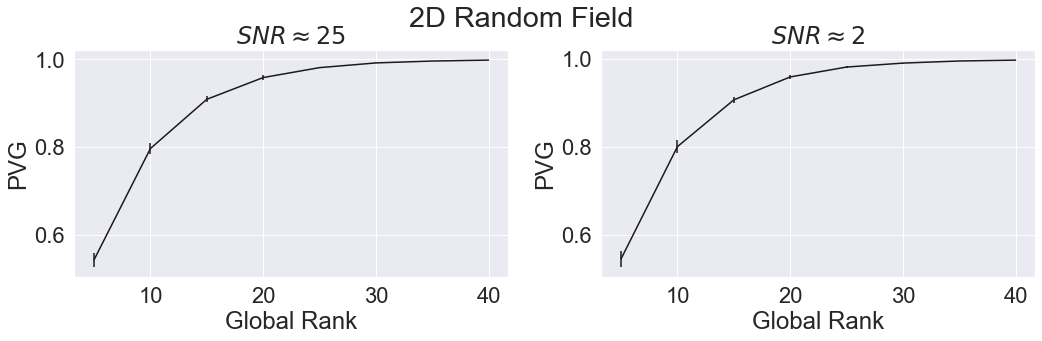

In [8]:
sns.set(font_scale = 2)

f, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].errorbar(Ks, np.mean(results_global_rank[0], axis=0), yerr=np.std(results_global_rank[0], axis=0),
              color="k")
ax[0].set_xlabel("Global Rank")
ax[0].set_ylabel("PVG")
ax[0].set_title(r'$SNR \approx %s$'%int(SNRs[0]))

ax[1].errorbar(Ks, np.mean(results_global_rank[1], axis=0), yerr=np.std(results_global_rank[1], axis=0),
               color="k")
ax[1].set_xlabel("Global Rank")
ax[1].set_ylabel("PVG")
ax[1].set_title(r'$SNR \approx %s$'%int(SNRs[1]))

plt.suptitle("2D Random Field")

f.tight_layout()
#plt.savefig("../../figures/sim_52_globrank_noline.pdf")

Plot some sample realizations.

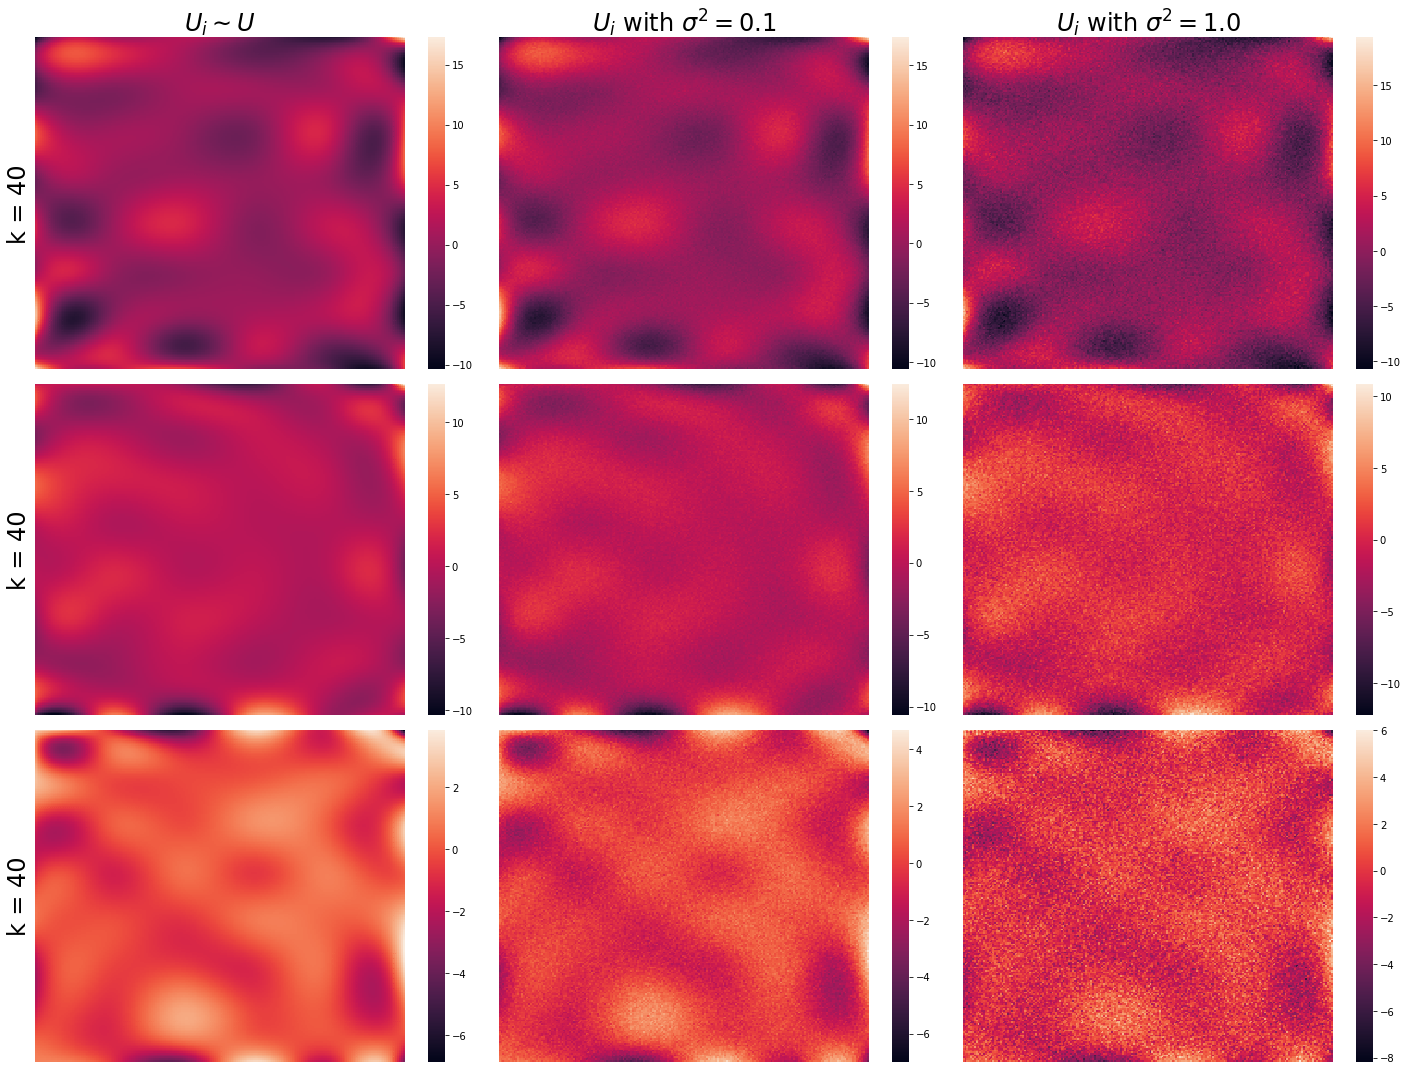

In [7]:
f, ax = plt.subplots(3, 3, figsize=(20,15))

Y = np.zeros((n1,n2,3))
Psi_coefs = np.random.multivariate_normal(np.zeros(m1*m2), np.diag(lambdas), size=3)
for i in range(3): 
    Y[:,:,i] = functools.reduce(operator.add,map(lambda k: Psi_coefs[i,k]*Psi_tensor[k,:,:], np.arange(m1*m2)))

Y_noisy_SNRhigh = Y + np.random.normal(loc=0, scale=np.sqrt(sigma2s[0]), size=Y.shape)
Y_noisy_SNRlow = Y + np.random.normal(loc=0, scale=np.sqrt(sigma2s[1]), size=Y.shape)

for n in range(3):
    
    ax_ = sns.heatmap(Y[:,:,n], ax=ax[n,0], xticklabels=False, yticklabels=False, rasterized=True)
    ax_.tick_params(left=False, bottom=False)
    ax_.set_ylabel(r'k = %s'%(k+1,),fontsize=24)
    
    ax_ = sns.heatmap(Y_noisy_SNRhigh[:,:,n], ax=ax[n,1], xticklabels=False, yticklabels=False, rasterized=True)
    ax_.tick_params(left=False, bottom=False)
    
    ax_ = sns.heatmap(Y_noisy_SNRlow[:,:,n], ax=ax[n,2], xticklabels=False, yticklabels=False, rasterized=True)
    ax_.tick_params(left=False, bottom=False)
    
ax[0,0].set_title(r'$U_i\sim U$',fontsize=24)
ax[0,1].set_title(r'$U_i$ with $\sigma^2=%s$'%sigma2s[0],fontsize=24)
ax[0,2].set_title(r'$U_i$ with $\sigma^2=%s$'%sigma2s[1],fontsize=24)

f.tight_layout()

# Automated Hyper-Parameter Selection and Eigenfunction Estimation

In [9]:
## selected above 
K = 30

## set parameter ranges 
lambda_c_grid = np.power(10, np.linspace(-12, -6, num=7))
lambda_s_grid = np.power(10, np.linspace(-12, -6, num=7))
Ntest = 50

## investigate fitting of first 3 eigenfunctions 
Kprime = 3

EigenApprox = {}
GeneralError = {}

for sigma2 in sigma2s:
    selected_params = np.zeros((Nrep, 3))
    EigenApprox[sigma2] = np.zeros((Nrep, Kprime))
    GeneralError[sigma2] = np.zeros(Nrep)
    for rep in range(Nrep):
        Y_true = sample_field(Ntrain)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        
        cross_val_results = tfold_cross_val(Y_noisey, K, Phis, Rlst, lambda_c_grid, lambda_s_grid, 
                                nfold=5, reg_type="l2", verbose=False)
        cross_val_results_tuple = [(k,v) for k, v in cross_val_results.items()]
        cross_val_selection = sorted(cross_val_results_tuple, key=lambda e: e[1], reverse=False)[0]
        lam_c, lam_s = cross_val_selection[0]
        
        pen_params = [lam_c]*nmode + [lam_s]
        
        ## compute two-stage eigenfunctions 
        Zeta_tensor, Clst, Ctilde, Smat_scaled = kompb(Y_noisey, K, pen_params, reg_type="l2")
        Eta_tensor, gamma = two_stage_fpca(Zeta_tensor, Clst, Smat_scaled)
        PVE = np.cumsum(gamma)/np.sum(gamma)
        for kk in range(Kprime):
            abs_inner_product = np.abs(tl.tenalg.inner(Psi_tensor[kk,:,:], Eta_tensor[kk,:,:])/(tl.norm(Psi_tensor[kk,:,:])*tl.norm(Eta_tensor[kk,:,:])))
            EigenApprox[sigma2][rep, kk] = 1-abs_inner_product
                
        ## evaluate on some independent test data
        Y_true = sample_field(Ntest)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        
        pen_params = [lam_c]*nmode + [lam_s]
        Zeta_tensor, Clst, Ctilde, Smat_scaled = kompb(Y_noisey, K, pen_params, reg_type="l2")
        
        Yhat = tl.tenalg.mode_dot(Zeta_tensor, Smat_scaled, 0)
        Yhat = np.moveaxis(Yhat, (0, 1, 2), (2, 0, 1))
        test_mse = (tl.norm(Y_true - Yhat)**2)/np.prod(Y_true.shape)
    
        GeneralError[sigma2][rep] = test_mse
        
    

In [10]:
print("MISE Results: ")
print('SNR ~ %s'%int(SNRs[0]), np.round(np.mean(GeneralError[sigma2s[0]]), 4))
print('SNR ~ %s'%int(SNRs[1]), np.round(np.mean(GeneralError[sigma2s[1]]), 4))

MISE Results: 
SNR ~ 19 0.0059
SNR ~ 1 0.0068


In [11]:
print("2-Stage FPCA")
Avg_Error = pd.DataFrame(np.column_stack((np.mean(EigenApprox[sigma2s[0]], axis=0).T, 
                                         np.mean(EigenApprox[sigma2s[1]], axis=0).T)), 
                                        columns=[r'$SNR \approx %s$'%int(SNRs[0]), 
                                                r'$SNR \approx %s$'%int(SNRs[1])], 
                                        index=["EF-1","EF-2","EF-3"])
                        
SE_Error = pd.DataFrame(np.column_stack((sem(EigenApprox[sigma2s[0]], axis=0).T, 
                 sem(EigenApprox[sigma2s[1]], axis=0).T)), 
                columns=[r'$SNR \approx %s$'%int(SNRs[0]), 
                        r'$SNR \approx %s$'%int(SNRs[1])], 
                index=["EF-1","EF-2","EF-3"])


print(Avg_Error.round(4).to_latex())
print(SE_Error.round(4).to_latex())

2-Stage FPCA
\begin{tabular}{lrr}
\toprule
{} &  \$SNR \textbackslash approx 19\$ &  \$SNR \textbackslash approx 1\$ \\
\midrule
EF-1 &            0.0167 &           0.0167 \\
EF-2 &            0.0312 &           0.0320 \\
EF-3 &            0.0393 &           0.0335 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  \$SNR \textbackslash approx 19\$ &  \$SNR \textbackslash approx 1\$ \\
\midrule
EF-1 &            0.0050 &           0.0041 \\
EF-2 &            0.0081 &           0.0065 \\
EF-3 &            0.0080 &           0.0051 \\
\bottomrule
\end{tabular}



We see strong estimation performance for both cases, with only slight degradation in quality for low SNR. 

# Illustrative Sparse Reconstruction Example: $l(\cdot) = \|\cdot\|_{1}$.

In this example, we simulate from the following model:

$$
    U_i = Z_1 \psi_1(x,y)I\{i\text{ in group 1}\} + Z_2\psi_2(x,y)I\{i\text{ in group 2}\} + \epsilon_i 
$$

Where samples $i=1,...,50$ samples are in group 1 and the remaining $i=51,...,100$ are in group two and $\epsilon_i\sim N(0,1)$. 

We then fit an MPB with $K=10$ and use $l(\cdot) = \|\cdot\|_{1}$ to promote sparsity on the resulting MPB coefficients. 

In [17]:
selected_param_results = {}
sigma2 = 1 ## set noise
K = 10 ## set rank 

Y_true  = sample_field_sparse(Ntrain)
Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)

lam_c = 1e-10
lam_s = .1 ## encourage sparsity 
pen_params = [lam_c]*nmode + [lam_s]
Zeta_tensor, Clst, Ctilde, Smat_scaled = kompb(Y_noisey, K, pen_params, reg_type="l1")

Yhat = tl.tenalg.mode_dot(Zeta_tensor, Smat_scaled, 0)
Yhat = np.moveaxis(Yhat, (0, 1, 2), (2, 0, 1))

mise = (tl.norm(Y_true - Yhat)**2)/(np.prod(Y_true.shape))

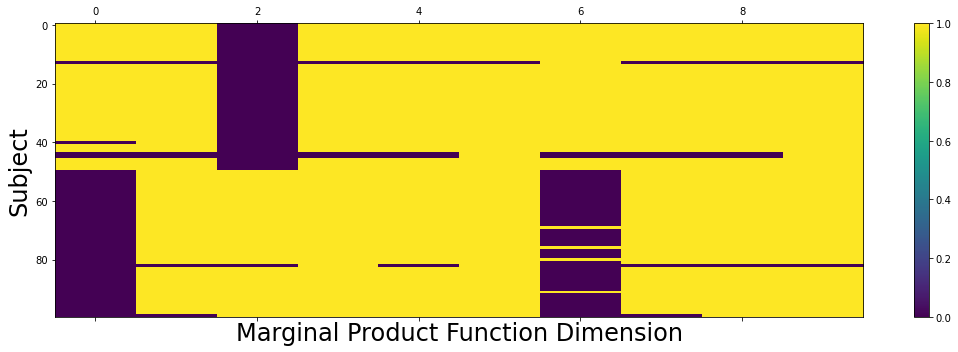

In [20]:
## plot spare MPB coefficients 
sns.reset_orig()

f, ax = plt.subplots(figsize=(15,5))

Smat_scaled[Smat_scaled != 0] = 1
pos = ax.matshow(Smat_scaled)
ax.set_aspect("auto")
f.colorbar(pos, ax=ax)

ax.set_xlabel("Marginal Product Function Dimension",fontsize=24)
ax.set_ylabel("Subject",fontsize=24)

f.tight_layout()

#plt.savefig("../../figures/interpretable_mpb.pdf")

The plot above shows the sparsity pattern of the resulting MPB coefficient matrix. A clear pattern in the sparsity profile between the group coefficient vectors (sample $< 50$ vs $ \ge 50$) is apparent, promoting interpretability of the resulting representations.